# 3D Atrophy Map 

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, MSE loss function, Mean MSE metric for image-to-image prediction.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" ||  pip install -q matplotlib
%matplotlib inline

: 

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Activations,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    RandFlipd,
    SaveImaged,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,

)
from monai.metrics import MSEMetric
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np


## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.1.dev2240
Numpy version: 1.23.1
Pytorch version: 1.13.0.dev20221003
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 92c329a5b0cd3b70e69a1ba55d415d2384f54b62
MONAI __file__: /Users/linhle/opt/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.5.1
TorchVision version: 0.14.0.dev20221003
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.5.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installat

## Set dataset path

In [4]:
root_dir = '/content/drive/MyDrive/data/'
print(root_dir)

from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab_Notebooks/unet.py .
!cp /content/drive/MyDrive/Colab_Notebooks/trainer.py .
!cp /content/drive/MyDrive/Colab_Notebooks/transformation.py .

/content/drive/MyDrive/data/


ModuleNotFoundError: No module named 'google.colab'

In [9]:
root_dir = '/Users/linhle/Documents/UC_Davis/Fan_Lab/atrophyData/'
import nibabel as nib
images = sorted(
    glob.glob(os.path.join(root_dir, "trainData/NIFTI/",  "*3DT1_Warped.nii")))
# images = sorted(
#     glob.glob(os.path.join(root_dir,  "*Fast_normalized.nii"))) #FLAIR
# images = sorted(
#     glob.glob(os.path.join(root_dir,  "*AV45_SUVR_Warped_mask.nii.nii"))) #AV45
segs = sorted(
    glob.glob(os.path.join(root_dir, "NewJacs/NIFTI/", "*MDT3_mask.nii")))

print(len(images))

# for i in range(92):
#   imData = nib.load(images[i])
#   im = imData.get_fdata()
#   # im = np.squeeze(im,axis=3)

#   segData = nib.load(segs[i])
#   seg = segData.get_fdata()
#   #seg = np.squeeze(seg,axis=3)

#   n = nib.Nifti1Image(im, np.eye(4))
#   nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

#   n = nib.Nifti1Image(seg, np.eye(4))
#   nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

NameError: name 'glob' is not defined

In [3]:
from torch.utils.data import random_split
# from sklearn.model_selection import train_test_split

root_dir = '/Users/linhle/Documents/UC_Davis/Fan_Lab/atrophyData/'

train_images = sorted(glob.glob(os.path.join(root_dir,"trainData/NIFTI/", "*3DT1_Warped.nii")))
# train_images = sorted(glob.glob(os.path.join(root_dir, "*Fast_normalized.nii")))
# train_images = sorted(glob.glob(os.path.join(root_dir, "*Warped_mask.nii.nii")))
train_labels = sorted(glob.glob(os.path.join(root_dir,"NewJacs/NIFTI/", "*MDT3_mask.nii")))
# train_labels = sorted(glob.glob(os.path.join(root_dir, "*Fast_normalized.nii")))
print(len(train_images))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:72], data_dicts[73:83]

# # random seed
# random_seed = 0

# # split dataset into training set and validation set
# train_size = 0.8  # 80:20 split

# train_files, val_files = train_test_split(
#     data_dicts, random_state=random_seed, train_size=train_size, shuffle=True
# )

# # Check length of the images and each set
print(len(train_images))
print(len(train_labels))
print(len(train_files))
print(len(val_files))

93
93
93
72
10


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"],roi_size=(128, 96, 128),random_size=False),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityd(
            keys=["image"], minv=0, maxv=1,
        ),
        # RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=1),
        # RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=2),
        # RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=3),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        #RandCropByPosNegLabeld(
        #    keys=["image", "label"],
        #    label_key="label",
        #    spatial_size=(128, 96, 128),
        #    pos=1,
        #    neg=1,
        #    num_samples=4,
        #    image_key="image",
        #    image_threshold=0,
        #),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        # RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=1),
        # RandFlipd(keys=["image","label"], prob=0.5, spatial_axis=2),
        ScaleIntensityd(
            keys=["image"], minv=0, maxv=1,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        RandSpatialCropd(keys=["image","label"],roi_size=(128, 96, 128),random_size=False),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

image shape: (128, 96, 128), label shape: (128, 96, 128)


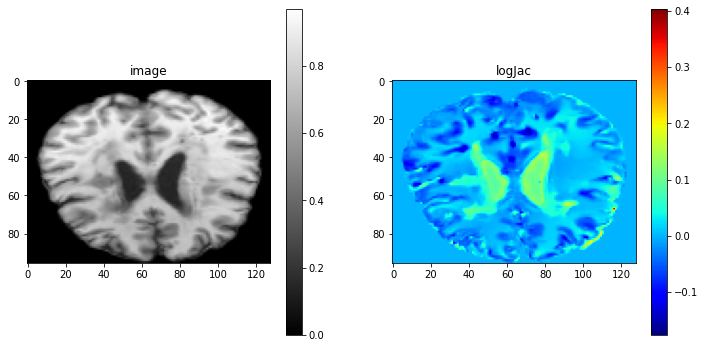

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.rot90(image[:, :, 80]), cmap="gray")
# plt.clim(vmin=0, vmax=1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("logJac")
plt.imshow(np.rot90(label[:, :, 80]),cmap='jet')
# plt.clim(vmin=0.8, vmax=1.5)
plt.colorbar()
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [7]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

print(train_loader)

Loading dataset: 100%|██████████| 10/10 [00:00<00:00, 25.10it/s]

## Create Model, Loss, Optimizer

In [8]:
#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
from unet import UNet

# device = torch.device("cuda:0")
device = torch.device("mps")

# model from monai UNET
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(32, 64, 128, 256, 512),
#     strides=(2, 2, 2, 2),
#     # norm=Norm.BATCH,
# ).to(device)

# model export from unet function 
model = UNet(
    in_channels=1,
    out_channels=1,
    n_blocks=5,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=3,
).to(device)

loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.HuberLoss(reduction='mean',delta=0.1)
# loss_function = SSIM(window_size=8, size_average=False, val_range=None)

lr=1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)

# from torchmetrics import MeanSquaredError
# mse_metric = MSEMetric(reduction="mean")
# mse_metric = MeanSquaredError()

# import pytorch_ssim
# import torch
# from torch.autograd import Variable

# loss_function = SSIM3D(window_size=11)

In [10]:
import torch
from trainer import Trainer
# Create a random dataset 
x = torch.randn(size=(2, 1, 128, 96, 128), dtype=torch.float32)

# with torch.no_grad():
#   out = model(x)

# print(f'Out: {out.shape}')

# # Print summary of the model 
# from torchinfo import summary
# summary(model, input_size=(1, 1, 96, 128, 96))

criterion = torch.nn.MSELoss()
# loss_function = torch.nn.HuberLoss(reduction='mean',delta=0.1)
# loss_function = SSIM(window_size=8, size_average=False, val_range=None)

lr=1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_loader,
                  validation_DataLoader=val_loader,
                  lr_scheduler=None,
                  max_epochs=2,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/9 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [ ]:
torch.cuda.empty_cache()

## Execute a typical PyTorch training process

In [17]:
max_epochs = 10
val_interval = 2
best_metric = 0.1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
ignore_index = 0
# post_pred = Compose([EnsureType()])
# post_label = Compose([EnsureType()])
post_pred = Compose(
    [Activations(other = lambda x: torch.tanh(x)), AsDiscrete(threshold=0.5)]
)
post_label = Compose(
    [Activations(other = lambda x: torch.tanh(x)), AsDiscrete(threshold=0.5)]
)
chosen_slice=80


# lr=1e-4
# optimizer = torch.optim.Adam(model.parameters(), lr)

for epoch in range(max_epochs):
    # epoch = epoch+100
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        print('shape of input',{inputs.shape})
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        #uncomment this when using SSIM loss
        #loss = 1-loss_function(outputs, labels)
        
        # Exclude background    
        mask = inputs != ignore_index 
        loss = (loss * (mask).float()).sum() # gives signal euclidean over unmasked elements
        non_zero_elements = mask.sum()
        loss = loss / non_zero_elements

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    train_loss = epoch_loss / len(train_loader)
    # epoch_loss /= step 
    epoch_loss_values.append(train_loss)
    print(len(epoch_loss_values))
    print(f"epoch {epoch + 1} average loss: {train_loss:.4f}")

    plt.title(f"epoch {epoch}")  
    plt.imshow(np.rot90(outputs[0].detach().cpu()[0, :, :, chosen_slice]),cmap="jet") 
    plt.clim(vmin=0.8,vmax=1.2)
    plt.colorbar()
    plt.axis('off')
    plt.show()
 
    mse_metric = 0 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                
                # Forward Pass
                val_outputs = model(val_inputs)
                # Find the Loss
                # mse_metric(y_pred=val_outputs, y=val_labels)
                # mse_metric(val_outputs, val_labels).to(device)
                metric_val = loss_function(val_outputs, val_labels)
                # Exclude background    
                mask = val_inputs != ignore_index 
                metric_val = (metric_val * (mask).float()).sum() # gives signal euclidean over unmasked elements
                non_zero_elements = mask.sum()
                metric_val = metric_val / non_zero_elements
                # Calculate Loss
                mse_metric += metric_val.item()

                # roi_size = (128, 96, 128)
                # sw_batch_size = 4
                # val_outputs = sliding_window_inference(
                #     val_inputs, roi_size, sw_batch_size, model)
                # val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                # val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # # compute metric for current iteration
                # mse_metric(y_pred=val_outputs, y=val_labels)

            metric = mse_metric / len(val_loader)
            # aggregate the final mean mse result
            # metric = mse_metric.aggregate().item()
            # reset the status for next validation round
            # mse_metric.reset()
            metric_values.append(metric)

            if metric < best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean MSE: {metric:.4f}"
                f"\nbest mean MSE: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/10
shape of input {(8, 1, 128, 96, 128)}


RuntimeError: Conv3D is not supported on MPS

In [ ]:
# model.eval()
# with torch.no_grad():
#     for val_data in val_loader:
#         val_inputs, val_labels = (
#             val_data["image"].to(device),
#             val_data["label"].to(device),
#         )
#         roi_size = (128, 96, 128)
#         sw_batch_size = 4
#         val_outputs = sliding_window_inference(
#             val_inputs, roi_size, sw_batch_size, model)
#         val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#         val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#         # compute metric for current iteration
#         mse_metric(y_pred=val_outputs, y=val_labels)

#     # aggregate the final mean mse result
#     metric = mse_metric.aggregate().item()
#     # reset the status for next validation round
#     mse_metric.reset()

#     print(
#         f"current mean MSE: {metric:.4f}"
#     )



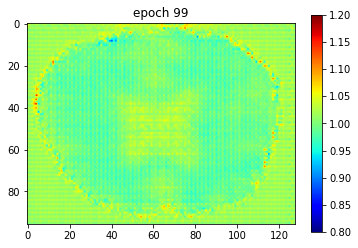

In [ ]:
    plt.title(f"epoch {epoch}")  
    plt.imshow(np.rot90(outputs[0].detach().cpu()[0, :, :, chosen_slice]),cmap="jet") 
    plt.clim(vmin=0.8,vmax=1.2)
    plt.colorbar()
    plt.show()

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

loss_pet = epoch_loss_values
metric_pet = metric_values

# loss_t1_flip_axis2 = epoch_loss_values
# metric_t1_flip_axis2 = metric_values

# loss_t1_huber_1e2 = epoch_loss_values
# metric_t1_huber_1e2 = metric_values

train completed, best_metric: 0.0007 at epoch: 244


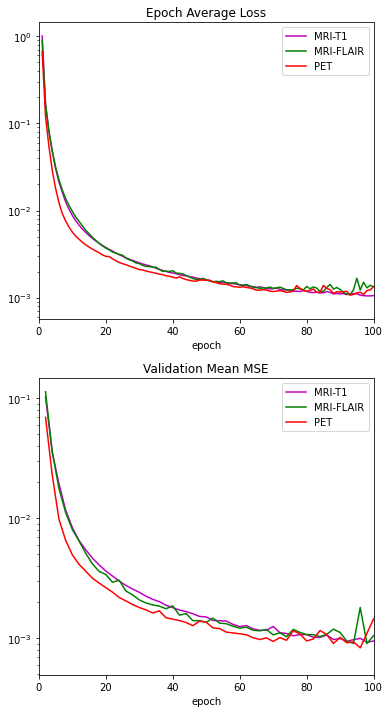

In [ ]:
plt.figure("train", (6, 12))
plt.subplot(2, 1, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.semilogy(x, loss_t1, 'm', label='MRI-T1')
plt.semilogy(x, loss_flair, 'g', label='MRI-FLAIR')
plt.semilogy(x, loss_pet, 'r', label='PET')
# plt.semilogy(x, loss_005, 'b', label='lr=0.05')
# plt.semilogy(x, y, 'r', label='lr=1e-2')
plt.xlim(0,100)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation Mean MSE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.semilogy(x, metric_t1, 'm', label='MRI-T1')
plt.semilogy(x, metric_flair, 'g', label='MRI-FLAIR')
plt.semilogy(x, metric_pet, 'r', label='PET')
# plt.semilogy(x, metric_005, 'b', label='lr=0.05')
# plt.semilogy(x, y, 'r', label='lr=1e-2')
plt.xlim(0,100)
plt.legend()
plt.show()

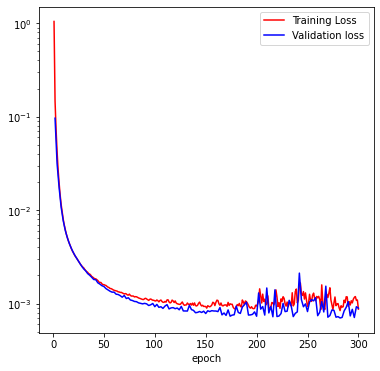

In [ ]:
# Overlay 2 figures
plt.figure("train", (6, 6))
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.semilogy(x, y, 'r', label='Training Loss')

x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.semilogy(x, y, 'b', label='Validation loss')

plt.legend()
plt.show()

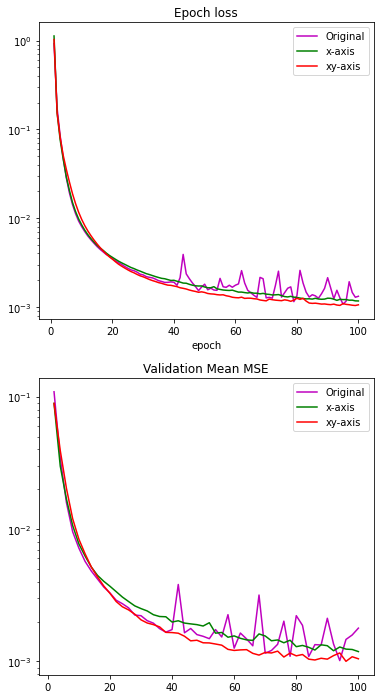

In [ ]:
# Overlay 2 figures
plt.figure("train", (6, 12))
plt.subplot(2, 1, 1)
plt.title("Epoch loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.semilogy(x, loss_t1, 'm', label='Original')
plt.semilogy(x, loss_t1_flip_axis1, 'g', label='x-axis')
plt.semilogy(x, loss_t1_flip_axis2, 'r', label='xy-axis')

plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation Mean MSE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.semilogy(x, metric_t1, 'm', label='Original')
plt.semilogy(x, metric_t1_flip_axis1, 'g', label='x-axis')
plt.semilogy(x, metric_t1_flip_axis2, 'r', label='xy-axis')


plt.legend()
plt.show()

## Plot the loss and metric

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


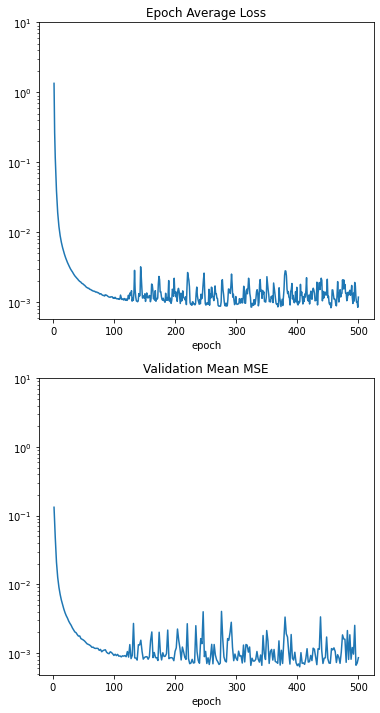

In [ ]:
plt.figure("train", (6, 12))
plt.subplot(2, 1, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.semilogy(x, y)
plt.ylim([0,10])
plt.subplot(2, 1, 2)

plt.title("Validation Mean MSE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.semilogy(x, y)
plt.ylim([0,10])
plt.show()

## Check best model output with the input image and label

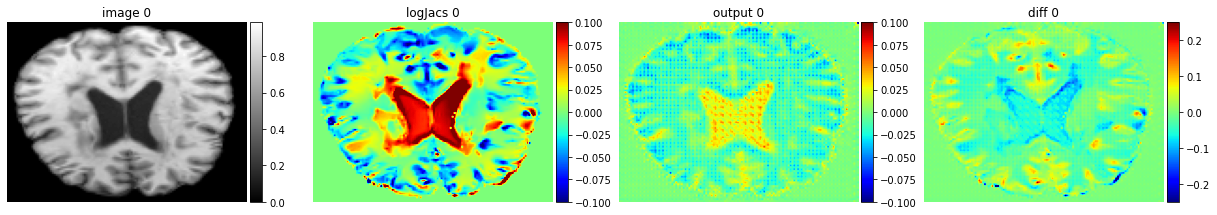

tensor(6.5449)


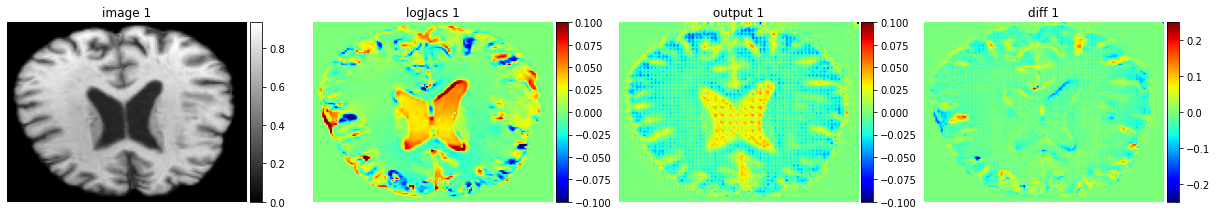

tensor(-650.4318)


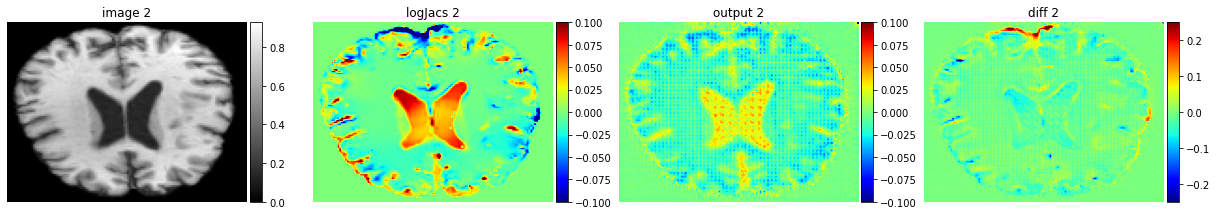

tensor(1461.1238)


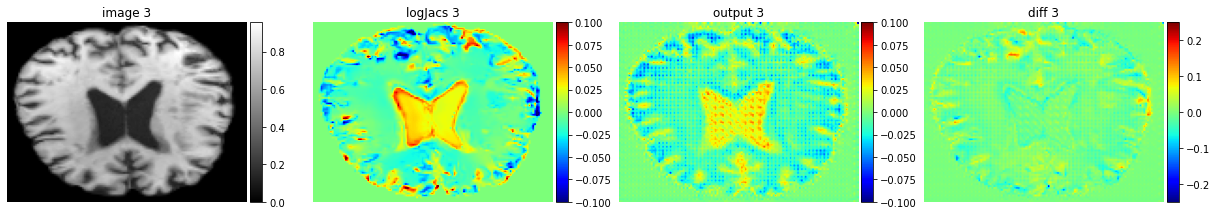

tensor(183.9147)


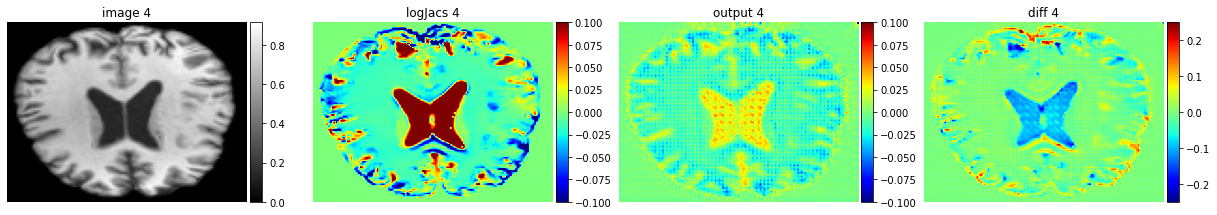

tensor(111.3404)


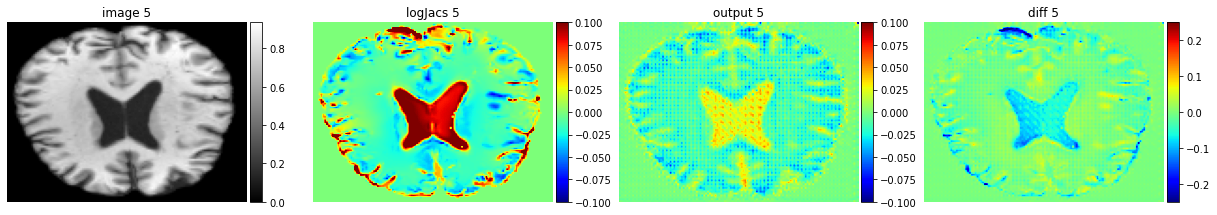

tensor(884.0070)


In [ ]:
import ignite.metrics.ssim

post_pred = Compose([EnsureType()])
post_label = Compose([EnsureType()])

from mpl_toolkits.axes_grid1 import make_axes_locatable
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))

model.eval()
device = torch.device("cuda:0")
model.to(device)
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_outputs = model(val_data["image"].to(device))
        # roi_size = (128, 96, 128)
        # sw_batch_size = 4
        # val_outputs = sliding_window_inference(
        #     val_data["image"].to(device), roi_size, sw_batch_size, model
        # )
        # plot the slice [:, :, 80]
        plt.figure("check", (21, 18))
        plt.subplot(1, 4, 1)
        plt.title(f"image {i}")
        ax = plt.gca()
        im=plt.imshow(np.rot90(val_data["image"][0, 0, :, :, 80]), cmap="gray")
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.subplot(1, 4, 2)
        plt.title(f"logJacs {i}")
        ax = plt.gca()
        im=plt.imshow(np.rot90(val_data["label"][0, 0, :, :, 80]-1), cmap="jet")
        plt.clim(vmin=-0.1, vmax=0.1)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.subplot(1, 4, 3)
        plt.title(f"output {i}")
        ax = plt.gca()
        #plt.imshow(torch.argmax(
        #    val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        #output_img = torch.argmax(val_outputs, dim=1).detach().cpu()
        #im=plt.imshow(np.rot90(output_img[0, :, :, chosen_slice],cmap="jet"))
        im=plt.imshow((np.rot90(val_outputs[0].detach().cpu()[0, :, :, 80]-1)),cmap="jet")
        plt.clim(vmin=-0.1, vmax=0.1)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.subplot(1, 4, 4)
        plt.title(f"diff {i}")
        ax = plt.gca()
        pred_img = np.rot90(val_outputs[0].detach().cpu()[0, :, :, 80]-1)
        label_img = np.rot90(val_data["label"][0, 0, :, :, 80]-1)
        im=plt.imshow((pred_img-label_img),cmap="jet")
        plt.clim(vmin=-0.25, vmax=0.25)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.show()


        y_true = val_data["label"]-1
        y_pred = val_outputs[0].detach().cpu()-1
        mask = val_data["image"] != 0 
        non_zero_elements = mask.sum()
        y_true_masked = (y_true * (mask).float()).sum() / non_zero_elements
        y_pred_masked = (y_pred * (mask).float()).sum() / non_zero_elements
        accuracy = ((y_pred_masked - y_true_masked) / y_true_masked)*100
        print(accuracy)

        if i == 5:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        # Orientationd(keys=["image"], axcodes="RAS"),
        #Spacingd(keys=["image"], pixdim=(
        #    1.5, 1.5, 2.0), mode="bilinear"),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        # CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    # Invertd(
    #     keys="pred",
    #     transform=val_org_transforms,
    #     orig_keys="image",
    #     meta_keys="pred_meta_dict",
    #     orig_meta_keys="image_meta_dict",
    #     meta_key_postfix="meta_dict",
    #     nearest_interp=False,
    #     to_tensor=True,
    # ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (128, 96, 128)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        mse_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = mse_metric.aggregate().item()
    # reset the status for next validation round
    mse_metric.reset()

print("Metric on original image spacing: ", metric_org)

RuntimeError: ignored

## Inference on Test Set

In [ ]:
#test_images = sorted(
#    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

# test_images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
test_images = sorted(glob.glob(os.path.join(root_dir, "*3DT1_Warped.nii")))

test_images = test_images[83:]
test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        # Orientationd(keys=["image"], axcodes="RAS"),
        # Spacingd(keys=["image"], pixdim=(
        #     1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityd(
            keys=["image"], minv=0, maxv=1,
        ),
        # ScaleIntensityRanged(
        #     keys=["image"], a_min=-57, a_max=164,
        #     b_min=0.0, b_max=1.0, clip=True,
        # ),
        # CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    # Invertd(
    #     keys="pred",
    #     transform=test_org_transforms,
    #     orig_keys="image",
    #     meta_keys="pred_meta_dict",
    #     orig_meta_keys="image_meta_dict",
    #     meta_key_postfix="meta_dict",
    #     nearest_interp=False,
    #     to_tensor=True,
    # ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = model(test_inputs)
        roi_size = (128, 96, 128)
        sw_batch_size = 2
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        # test_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 80], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[0, :, :, 80])
        plt.colorbar()
        plt.show()

KeyError: ignored

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)